# Hand Sign Classification MNIST

Willkommen zu diesem Notizbuch mit mehrklassiger Klassifizierung von Handzeichen! In diesem Notebook werden wir an einem **Klassifikationsproblem** mit mehreren Klassen arbeiten. Wir werden den **Sign Language** **MNIST-Datensatz** verwenden, der 28x28-Bilder von Händen enthält, die die 26 Buchstaben des englischen Alphabets darstellen. Um eine **Multi-Class-Klassifizierung** durchzuführen, verwenden wir **CNN** (Wir können auch vortrainierte Modelle oder andere neuronale Netzwerke verwenden, es hängt davon ab, welches Modell besser führt).

Lass uns anfangen!

In [1]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Laden Sie die Trainings- und Testsets herunter (das Testset wird tatsächlich als Validierungsset verwendet):

In [2]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 92.9MB/s]


Definieren Sie einige Globals mit dem Pfad zu beiden Dateien, die Sie gerade heruntergeladen haben:

In [3]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Sie erhalten nicht die eigentlichen Bilder, sondern die Daten werden als **CSV**-Dateien serialisiert.

Sehen Sie sich an, wie die Daten in der CSV-Datei aussehen:

In [4]:
with open(TRAINING_FILE) as training_file:
  line = training_file.readline()
  print(f"First line (header) looks like this:\n{line}")
  line = training_file.readline()
  print(f"Each subsequent line (data points) look like this:\n{line}")

First line (header) looks like this:
label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pix

# Analysieren des Datensatzes

In [5]:
# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  with open(filename) as file:
    ### START CODE HERE
    
    # Use csv.reader, passing in the appropriate delimiter
    # Remember that csv.reader can be iterated and returns one line in each iteration
    csv_reader = csv.reader(file, delimiter=',')
    imgs = []
    labels = []
    next(csv_reader, None)
    for row in csv_reader:
      label = row[0]
      data = row[1:]
      img = np.array(data).reshape((28,28))

      imgs.append(img)
      labels.append(label)
    
    labels = np.array(labels).astype(float)
    images = np.array(imgs).astype(float)

    
    ### END CODE HERE

    return images, labels

In [6]:
# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape}")
print(f"Training labels has shape: {training_labels.shape}")
print(f"Validation images has shape: {validation_images.shape}")
print(f"Validation labels has shape: {validation_labels.shape}")

Training images has shape: (27455, 28, 28)
Training labels has shape: (27455,)
Validation images has shape: (7172, 28, 28)
Validation labels has shape: (7172,)


# Visualisieren der numpy-Arrays

Nachdem Sie die ursprünglichen CSV-Daten in ein Format konvertiert haben, das mit Computer-Vision-Aufgaben kompatibel ist, nehmen Sie sich einen Moment Zeit, um zu sehen, wie die Bilder des Datensatzes tatsächlich aussehen:

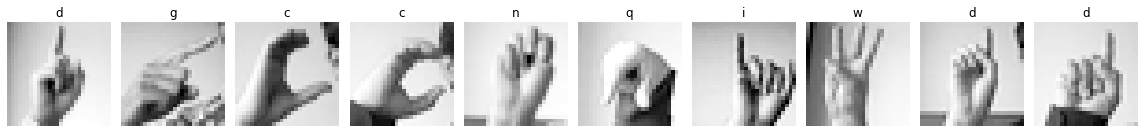

In [7]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

# Erstellen der Generatoren für das CNN

In [8]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  ### START CODE HERE

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)
  # Hint: np.expand_dims
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values 
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(
      rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
  )


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=32) 

  
  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale=1./255.)

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=32) 

  ### END CODE HERE

  return train_generator, validation_generator

In [9]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)


# Codierung des CNN

**Ein letzter Schritt** vor dem Training besteht darin, die Architektur des zu trainierenden Modells zu definieren.

In [10]:
def create_model():

  ### START CODE HERE       

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(32,(3,3), activation='relu',input_shape=(28,28,1)),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
                                      tf.keras.layers.MaxPooling2D(2,2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(512, activation='relu'),
                                      tf.keras.layers.Dense(26, activation='softmax')
  ])
  

  model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE       
  
  return model

In [11]:
# Save your model
model = create_model()

# Train your model
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator)

Epoch 1/15
858/858 [==============================] - 37s 42ms/step - loss: 2.6054 - accuracy: 0.2048 - val_loss: 1.5654 - val_accuracy: 0.5185
Epoch 2/15
858/858 [==============================] - 37s 43ms/step - loss: 1.7928 - accuracy: 0.4232 - val_loss: 1.3044 - val_accuracy: 0.5158
Epoch 3/15
858/858 [==============================] - 36s 42ms/step - loss: 1.4031 - accuracy: 0.5444 - val_loss: 0.9746 - val_accuracy: 0.6520
Epoch 4/15
858/858 [==============================] - 35s 41ms/step - loss: 1.1619 - accuracy: 0.6205 - val_loss: 0.6793 - val_accuracy: 0.7648
Epoch 5/15
858/858 [==============================] - 35s 41ms/step - loss: 0.9904 - accuracy: 0.6710 - val_loss: 0.6383 - val_accuracy: 0.7773
Epoch 6/15
858/858 [==============================] - 35s 41ms/step - loss: 0.8616 - accuracy: 0.7137 - val_loss: 0.5849 - val_accuracy: 0.7953
Epoch 7/15
858/858 [==============================] - 35s 41ms/step - loss: 0.7835 - accuracy: 0.7393 - val_loss: 0.3713 - val_accuracy:

einen Blick auf Ihre Trainingshistorie:

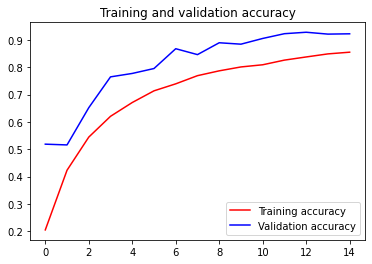

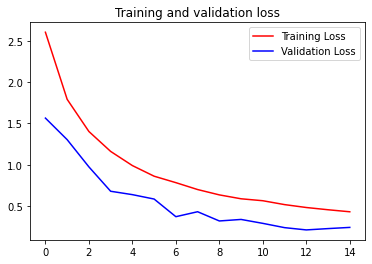

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()